In [1]:
options(warn=-1)
suppressPackageStartupMessages({
    library(tidyverse) 
    library(rtweet)
    library(tidytext)
    library(stopwords)
    library(scales)     
    library(lubridate)
    library(corrplot)        
}) 
                 
theme_set(theme_light())
color1 <- c("#EC7063", "#5DADE2", "#58D68D", "#AF7AC5")

### Import data

A Twitter user must register a developer account to have access to the Twitter API. Afterwards, it is possible to retrieve a limited amount of tweets directly to R using the _rtweet_ library. Personal tokens are generated with each app. Here, I have already downloaded data from Twitter from October 2020 for the analysis. I will import the dataset to see the number of tweets per media outlet.

In [2]:
# Importing tweets
tw_original <- read_twitter_csv("media.csv")

tw_original %>%
    group_by(name) %>%
    summarize(n = n()) %>%
    rename(Media_outlet = name,
          Tweets = n)
        

Media_outlet,Tweets
Bloomberg,3200
Financial Times,3199
The New York Times,3200
The Wall Street Journal,3200
The Washington Post,3200


### Filter and time period
The raw data from twitter comes with 90 variables, but fur the purposes of this analysis I will only focus on the variables with information about the user and the text inside the tweet. The first filter I apply is language. I will only be using tweets in English. I also want to check how far the timeline for each media outlet goes into the past.

In [3]:
# Filtering tweets and variables 
tw_media <- tw_original %>%
  mutate(date = as_datetime(created_at)) %>%
  filter(lang == "en") %>%
  select(name, date, text, source, is_retweet, favorite_count, 
         retweet_count, lang, geo_coords, status_id)

# Defining time period
tw_media %>%
  group_by(name) %>%
  mutate(n = n(),
         initial = min(date),
         diff = max(date) - min(date)) %>%
  select(name, n, initial, diff) %>% 
  unique() %>%
  rename(Media_outlet = name,
         Tweets = n,
         First_tweet_timestamp = initial,
         Timeline_period = diff) 

Media_outlet,Tweets,First_tweet_timestamp,Timeline_period
The Wall Street Journal,3198,2020-09-21 00:47:36,35.79410 days
The New York Times,3180,2020-09-24 17:33:43,32.09125 days
Bloomberg,3194,2020-10-15 12:27:03,11.29861 days
Financial Times,3184,2020-09-03 08:54:29,53.44138 days
The Washington Post,3186,2020-09-21 16:18:06,35.14439 days


I will filter out Bloomberg to have an even number of media outlets and I will set the first tweet from _The Wall Street Journal_ as the initial point in time for the entire dataset. By doing this, I am making sure that the timeline for each media outlet covers the exact same period. Therefore, they will be covering the same news and events.

In [4]:
tw_media <- tw_media %>%
  filter(name != 'Bloomberg',
         date >= min(date[which(name == "The Wall Street Journal")]))

# Number of tweets for each outlet
tw_media %>%
  group_by(name) %>%
  summarise(n = n()) %>%
  rename(Media_outlet = name,
         Tweets = n)

Media_outlet,Tweets
Financial Times,2135
The New York Times,3180
The Wall Street Journal,3198
The Washington Post,3186


### Data wrangling and tokenization

In [5]:
# checking for retweets
tw_media %>%
  group_by(name, is_retweet) %>%
  count() %>%
  rename(Media_outlet = name,
         Retweet = is_retweet,
         Tweets = n)

Media_outlet,Retweet,Tweets
Financial Times,FALSE,1771
Financial Times,TRUE,364
The New York Times,FALSE,2564
The New York Times,TRUE,616
The Wall Street Journal,FALSE,3149
The Wall Street Journal,TRUE,49
The Washington Post,FALSE,3008
The Washington Post,TRUE,178


Even though some tweets will repeat themselves, I will keep retweets, since the point is too identify what kind of news where given more attention in the timeline. That includes retweets as well.

To check for specific words in a tweet, I have to tokenize the text. This means that the text will be broken apart following a pattern, which considers individual words and deletes punctuation and urls. Moreover, I delete stopwords which don't add meaningful information to this part of the analysis.

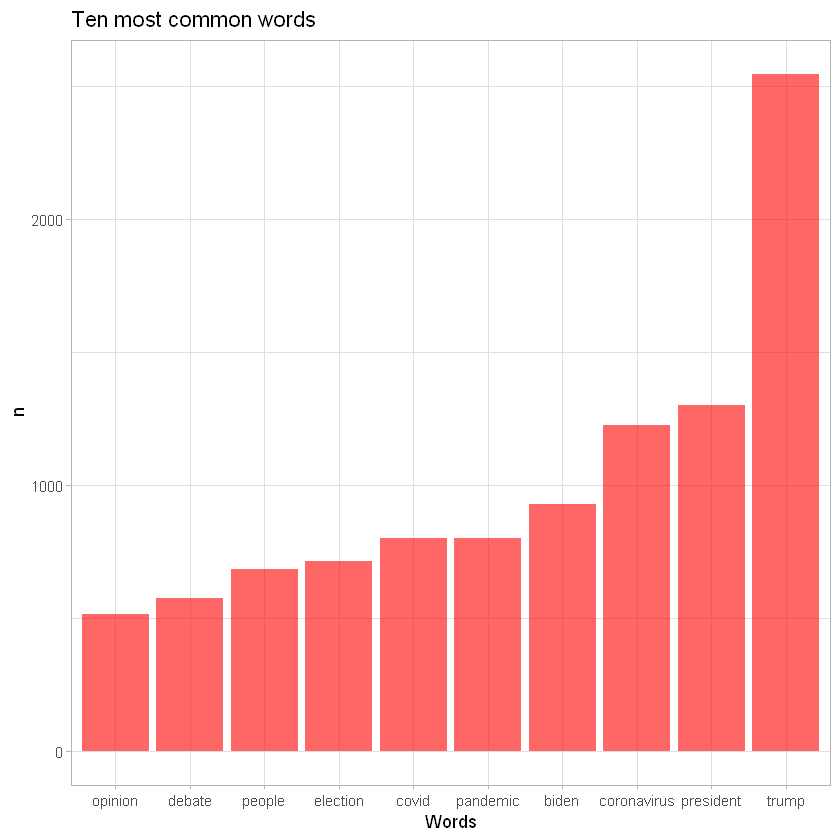

In [6]:
# Pattern
reg <- "([^A-Za-z\\d#@']|'(?![A-Za-z\\d])|'s|(?<=\\s)')" 

tw_words <- tw_media %>%
  #filter(is_retweet == FALSE) %>% #checking for retweets
  select(-geo_coords, -favorite_count, -retweet_count) %>%
  mutate(text = str_replace_all(text, "https://t.co/[A-Za-z\\d]+|&amp;", "")) %>%
  unnest_tokens(words, text, token = "regex", pattern = reg) %>% 
  filter(!words %in% stop_words$word, #word not in stop_words
         !str_detect(words, "^000"),
         str_detect(words, "[a-z]"))

# 10 most common words
tw_words %>%
  count(words) %>%
  arrange(desc(n)) %>%
  top_n(10, n) %>%
  ggplot(aes(reorder(words,n), n)) +
  geom_bar(stat = "identity", fill = "red", alpha = 0.6) + 
  ggtitle("Ten most common words") +
  xlab("Words") +
  ylab("n")

The first word  appears almost two times more than the second most common word. At first glance, it looks
like all the words relate between one another, with two distinguishable topics: US election and the pandemic.

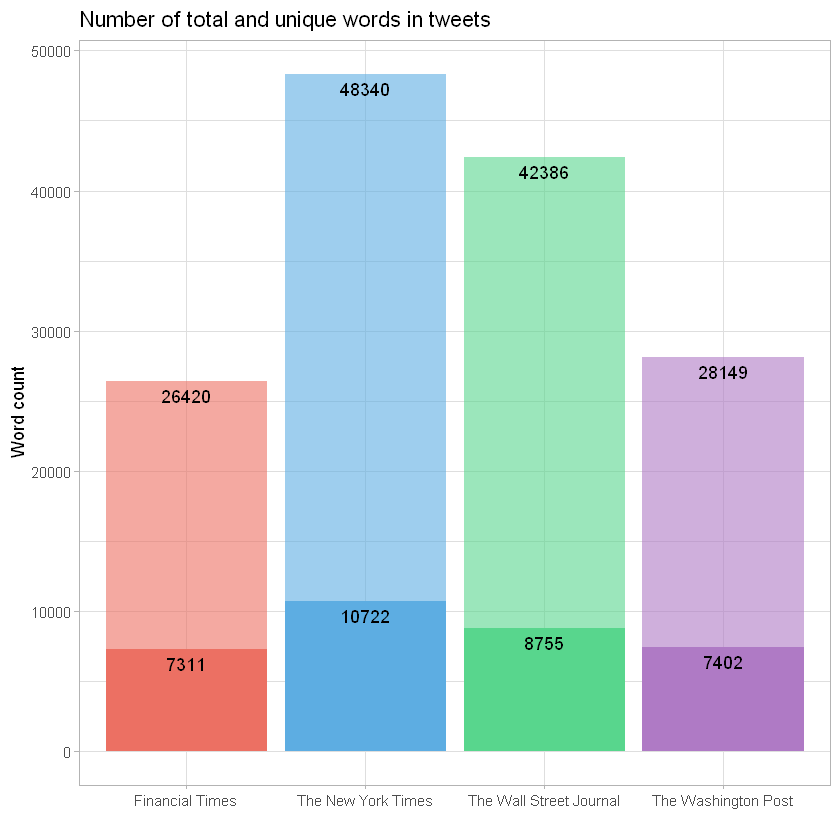

In [7]:
# number of total words
tw_words %>%
  group_by(name) %>%
  count(words) %>%
  mutate(total_words = sum(n),
         unique_words = n()) %>%
  select(name, total_words, unique_words) %>% unique() %>%
  ggplot(aes(x = name, y = total_words,  fill = name)) +
  geom_bar(stat = 'identity', show.legend = FALSE, alpha = 0.6) +
  geom_bar(aes(y = unique_words), stat = 'identity', show.legend = FALSE) +
  geom_text(aes(label = total_words), nudge_y = -1000) +
  geom_text(aes(y = unique_words, label = unique_words), nudge_y = -1000) +
  ggtitle('Number of total and unique words in tweets') +
  scale_fill_manual(values = color1) +
  xlab('') +
  ylab('Word count')

The NYT is the one with the most words followed by the WSJ. The darker color shows the number of unique words used in each timeline At this level, there is less variability than in the count for total words.

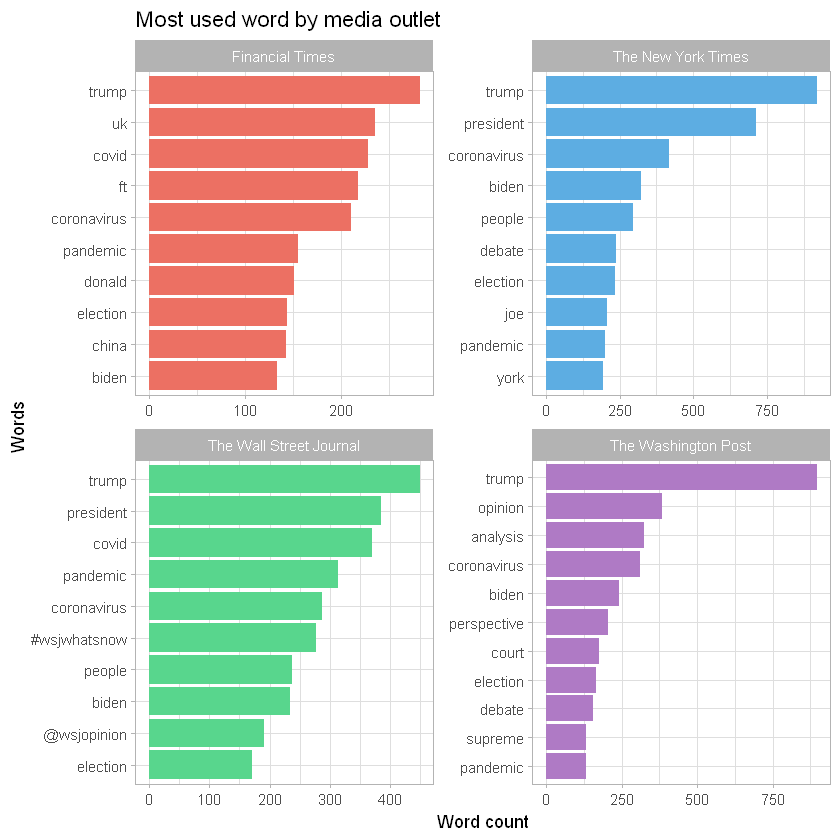

In [8]:
# most used words by media
tw_words %>% 
  group_by(name) %>%
  count(words) %>%
  top_n(10, n) %>%
  ggplot(aes(reorder_within(words, n, name), n, fill = name)) +
  geom_col(show.legend = FALSE) +
  scale_x_reordered() +
  coord_flip() +
  facet_wrap(. ~ name, scales = "free") +
  ggtitle('Most used word by media outlet') +
  scale_fill_manual(values = color1) +
  ylab('Word count') +
  xlab('Words')

For these four newspapers, the most used word in this period is 'trump', although it is noticeable that this word has a bigger difference than the rest of words for the politics-focused outlets, than for the economics-focused outlets. Nonetheless, it is also clear that the words used by the all of these outlets remain similar. The highlight in this period was around the US election and the pandemic. Also noteworthy is the fact that FT and the WSJ use 'covid' more often than 'coronavirus', in contrast to the NYT and the WP. For this set of words, there is more variability in the NYT and WP, than in the WSJ and FT.

### Word frequencies as proportion and correlation

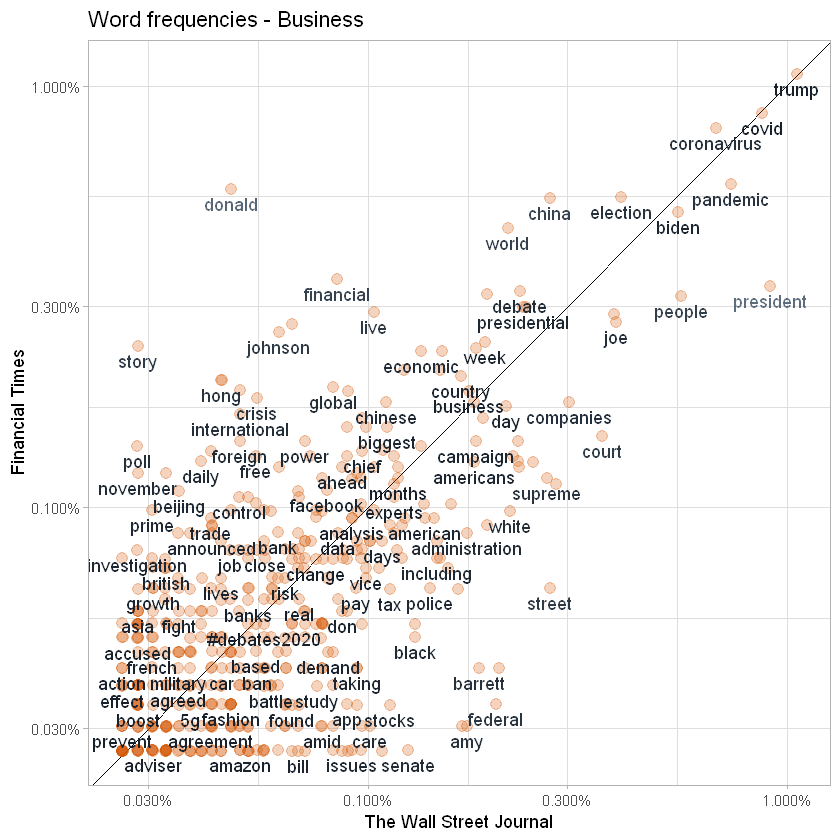

In [9]:
# Business-focused
frequency_eco <- tw_words %>%
  filter(!name %in% c("The New York Times", "The Washington Post")) %>%
  count(name, words) %>%
  group_by(name) %>%
  mutate(proportion = n/sum(n)) %>%
  select(-n) %>%
  spread(name, proportion)

frequency_eco %>%
  filter(`The Wall Street Journal` > 0.00025,
         `Financial Times` > 0.00025) %>%
  ggplot(aes(`The Wall Street Journal`, `Financial Times`, color = abs(`Financial Times` - `The Wall Street Journal`))) +
  geom_abline(color = "black") +
  geom_point(color = "#D35400", alpha = 0.25, size = 3, position = position_jitter(seed = 1), show.legend = FALSE) +
  geom_text(aes(label = words), check_overlap = TRUE, position = position_jitter(seed = 1), vjust = 1.5, show.legend = FALSE) + 
  scale_x_log10(labels = percent_format()) +
  scale_y_log10(labels = percent_format()) +
  scale_color_gradient(low = "#17202A", high = "#5D6D7E") +
  ggtitle("Word frequencies - Business")

This plot shows the correlation between word frequencies in FT and WSJ. Words such as 'trump', 'covid', 'coronavirus' are the most frequent words and equally used in both timelines. The word 'president' is more used in WSJ, whereas 'donald' appears more frequently in FT. Moreover, it is possible to identify clusters of words in both outlets that point to specific topics being covered more in one outlet than in other. For instance, the words 'amy', 'barrett', 'supreme' and 'court' appear more often in WSJ. Words like 'china', 'chinese', 'beijing' and 'asia' are more likely to appear in FT than in WSJ.

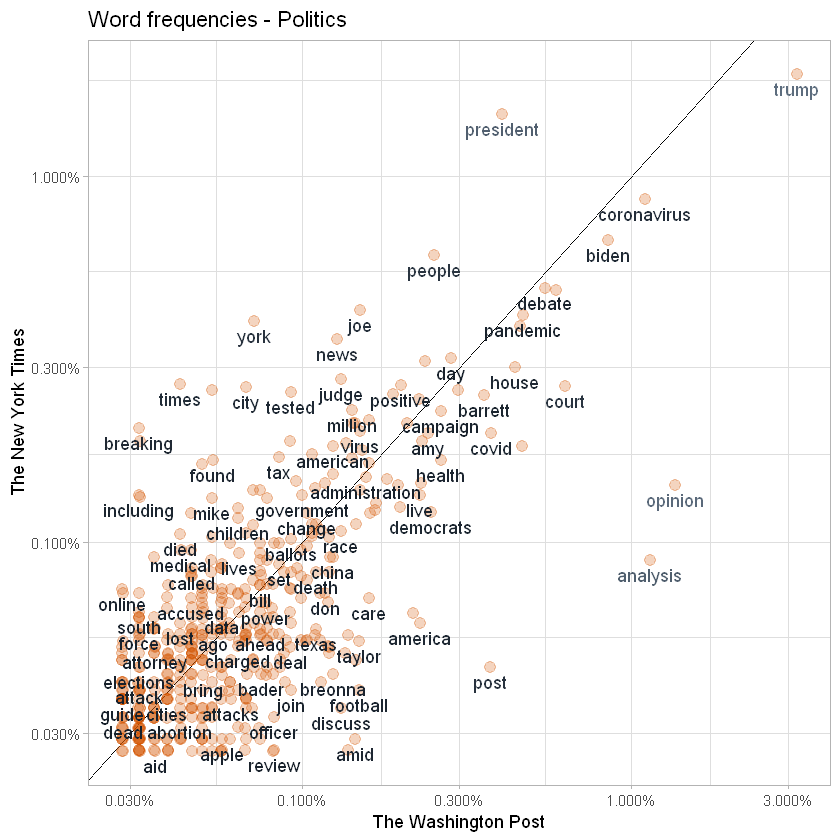

In [10]:
# Politics-focused
frequency_pol <- tw_words %>%
  filter(name %in% c("The New York Times", "The Washington Post")) %>%
  count(name, words) %>%
  group_by(name) %>%
  mutate(proportion = n/sum(n)) %>%
  select(-n) %>%
  spread(name, proportion)

frequency_pol %>%
  filter(`The Washington Post` > 0.00025,
         `The New York Times` > 0.00025) %>%
  ggplot(aes(`The Washington Post`, `The New York Times`, color = abs(`The New York Times` - `The Washington Post`))) +
  geom_abline(color = "black") +
  geom_point(color = "#D35400", alpha = 0.25, size = 3, position = position_jitter(seed = 1), show.legend = FALSE) +
  geom_text(aes(label = words), check_overlap = TRUE, position = position_jitter(seed = 1), vjust = 1.5, show.legend = FALSE) + 
  scale_x_log10(labels = percent_format()) +
  scale_y_log10(labels = percent_format()) +
  #scale_color_gradient(low = "black", high = "red") +
  scale_color_gradient(low = "#17202A", high = "#5D6D7E") +
  ggtitle("Word frequencies - Politics")

In the case of politics-focused media outlets, the correlation is visually less spread out than in the previous case. There are few noticeable clusters of outliers, since most words are close to the reference line. The word that stands out is 'trump' with a higher proportion appearing in the WP, than in the NYT.

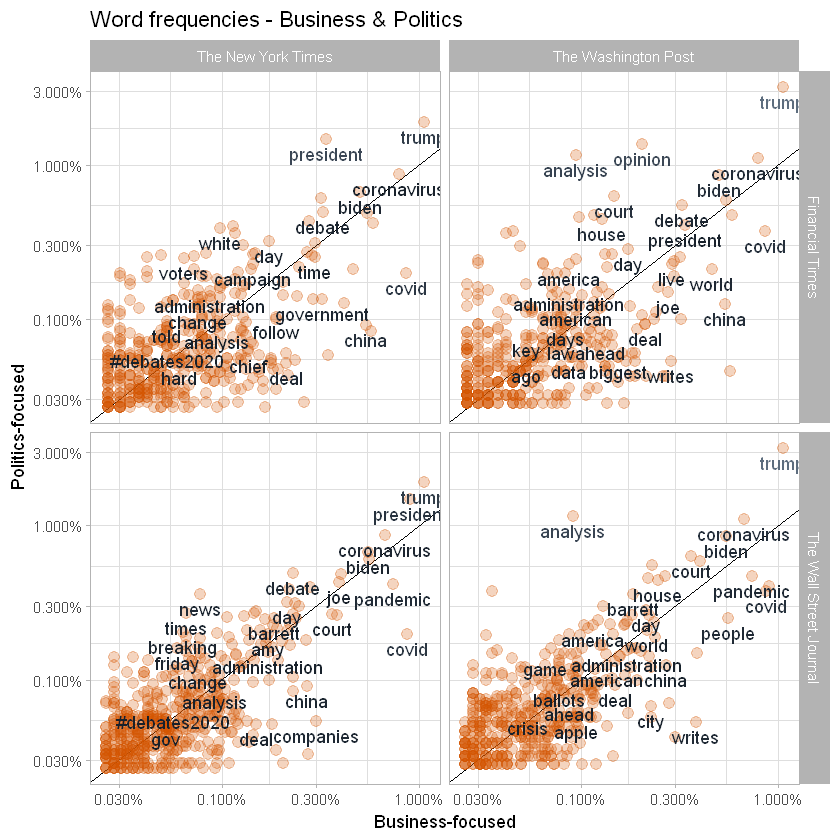

In [11]:
# Total
frequency_total <- tw_words %>%
  count(name, words) %>%
  group_by(name) %>%
  mutate(proportion = n/sum(n)) %>%
  select(-n) %>%
  spread(name, proportion) %>%
  gather(name_eco, proportion_eco, c('Financial Times','The Wall Street Journal')) %>%
  gather(name_pol, proportion_pol, c('The New York Times', 'The Washington Post'))

frequency_total %>%
  filter(proportion_eco > 0.00025,
         proportion_pol > 0.00025) %>%
  ggplot(aes(proportion_eco, proportion_pol, color = abs(proportion_eco - proportion_pol))) +
  geom_abline(color = "black") +
  geom_point(color = "#D35400", alpha = 0.25, size = 3, position = position_jitter(seed = 1), show.legend = FALSE) +
  geom_text(data = subset(frequency_total, proportion_eco >= 0.0005 & proportion_pol >= 0.0005), #0.001 - 0.0005
    aes(label = words), check_overlap = TRUE, position = position_jitter(seed = 1), vjust = 1.5, show.legend = FALSE) +
  scale_x_log10(labels = percent_format()) +
  scale_y_log10(labels = percent_format()) +  
  scale_color_gradient(low = "#17202A", high = "#5D6D7E") +
  ggtitle("Word frequencies - Business & Politics") +
  xlab("Business-focused") +
  ylab("Politics-focused") +
  facet_grid(name_eco ~ name_pol)

When comparing between the two groups of media outlets the word 'trump' and words related to the pandemic are the most common in terms of frequency. Visually, it appears that the frequency of words is more spread out when comparing the WP to the two business-focused outlets, especially with FT. This would point out the different coverage in topics. However, it appears that there is a close correlation between the NYT and the WSJ. 

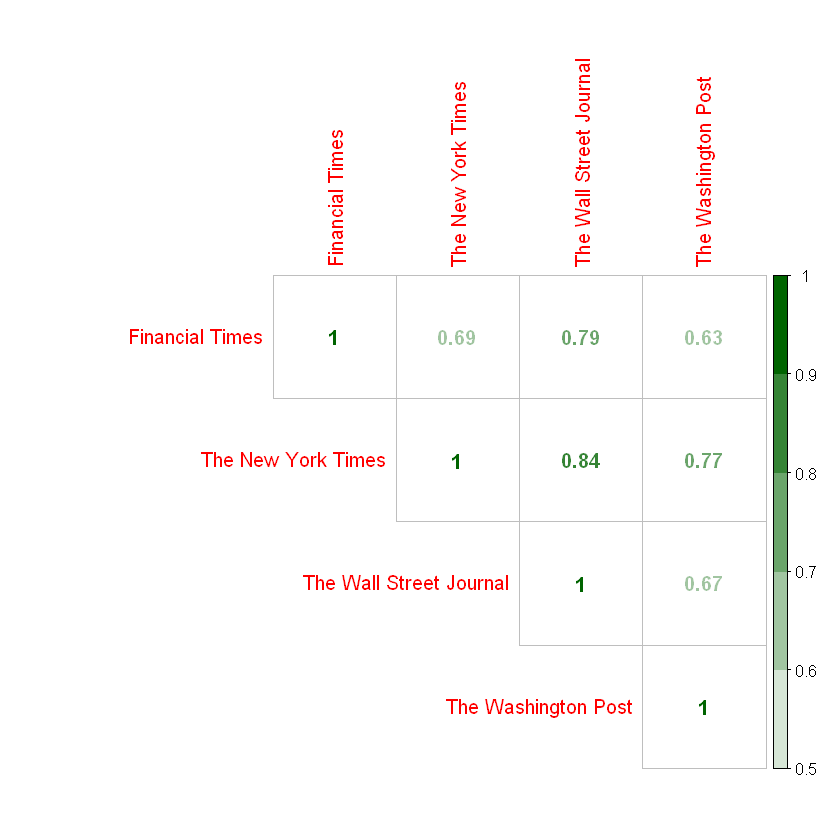

In [12]:
corr_media <- tw_words %>%
  count(name, words) %>%
  group_by(name) %>%
  mutate(proportion = n/sum(n)) %>%
  select(-n) %>%
  spread(name, proportion) %>%
  drop_na() %>%
  select(-words) %>%
  cor()

corrplot(corr_media, method = "number", type = "upper", 
         col = colorRampPalette(c("black", "black", "black", "white", "darkgreen"))(20), cl.lim = c(0.5, 1)) 

A correlation matrix of word frequencies shows that the NYT and WSJ are the most similar media outlets from this sample of tweets. The politics-focused outlets have 0.77, whereas the business-focused have 0.79. The rest of cases are under 0.70.

### Timeline

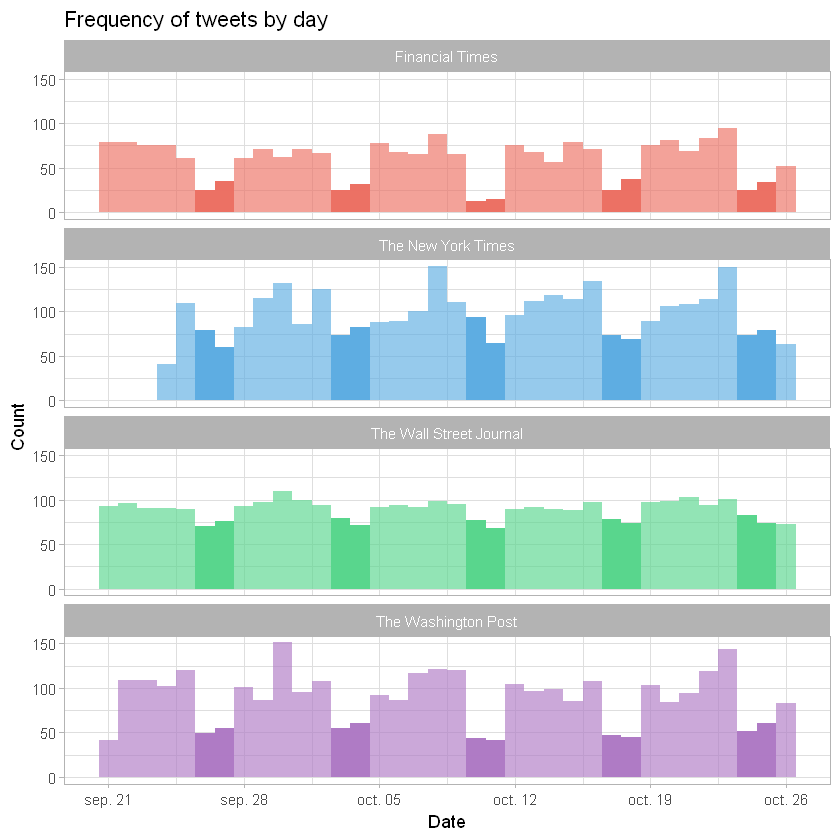

In [13]:
tw_media %>%
  #filter(is_retweet == FALSE) %>%
  ggplot(aes(as.Date(date), fill = name)) +  
  geom_histogram(position = 'identity', binwidth = 1, show.legend = FALSE, alpha = 0.65) +
  geom_histogram(data = subset(tw_media %>%
                                 #filter(is_retweet == FALSE) %>%
                                 mutate(wknds = wday(date)), 
                               wknds==7 | wknds==1), # Saturday and Sunday
                 binwidth = 1, alpha = 0.99, show.legend = FALSE) +
  ggtitle("Frequency of tweets by day") +
  xlab("Date") +
  ylab("Count") +
  scale_fill_manual(values = color1) +
  facet_wrap(.~ name, ncol = 1)

As for the frequency, it looks like the outlets all share an almost uniform distribution with some exceptions (fridays). The darker areas represent the weekends with fewer tweets in comparison to weekdays. When removing retweets, the distribution remains the same, which suggests that retweets are more or less evenly distributed along the timeline.

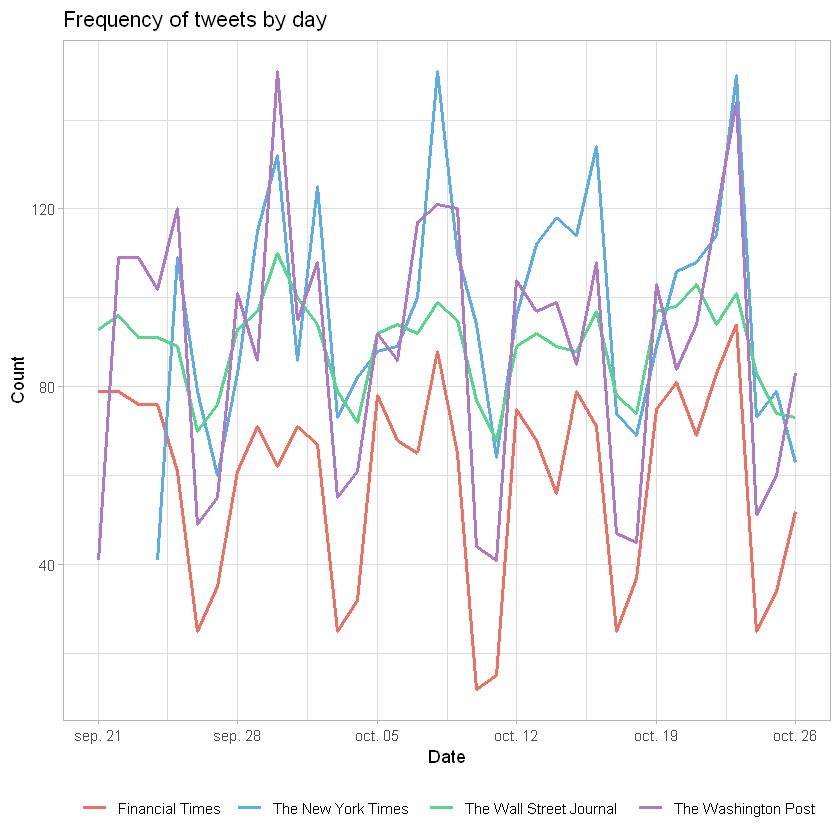

In [14]:
### rate
tw_media %>%
  mutate(date = as_date(date)) %>%
  group_by(name, date) %>%
  mutate(n = n()) %>%
  ggplot(aes(date, n, color = name)) +
  geom_line(size = 1) +
  ggtitle("Frequency of tweets by day") +
  xlab("Date") +
  ylab("Count") +
  scale_color_manual(values = color1) +
  theme(legend.position = "bottom",
        legend.title = element_blank())

Visually, it looks like the two politics-focused media outlets have a higher average rate of tweets on weekdays than the business-focused outlets. This difference is more evident towards the end of the week. 

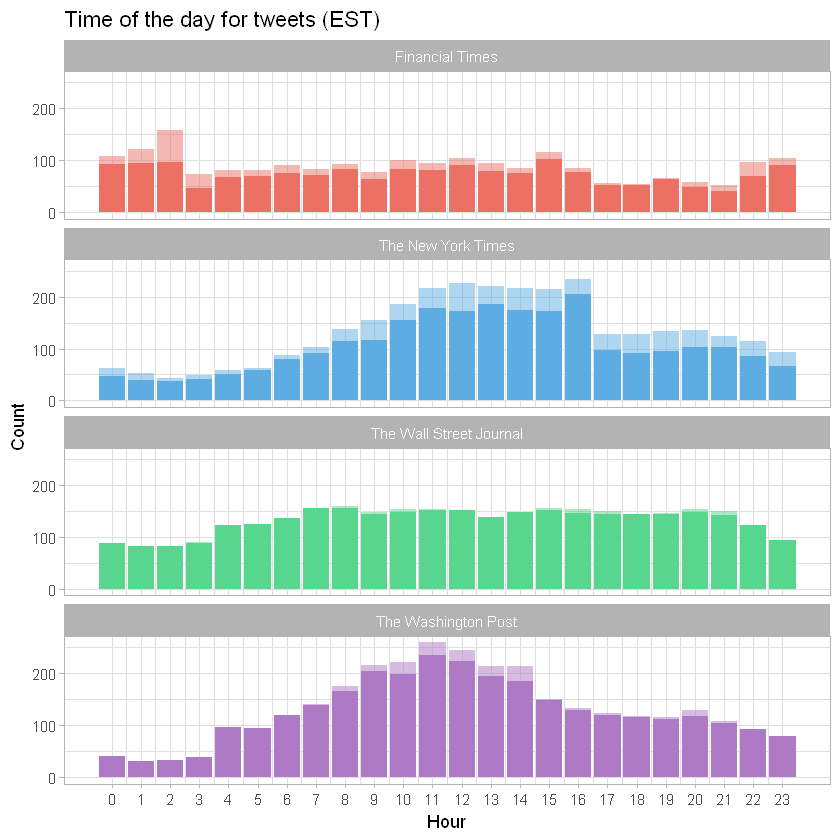

In [15]:
### daytime
tw_media %>%
  count(name, hour = hour(with_tz(date, 'EST'))) %>% 
  mutate(percent = n / sum(n)) %>%
  ggplot(aes(hour, n, fill = name)) +
  geom_bar(stat = 'identity', show.legend = FALSE, alpha = 0.5) +
  geom_bar(data = subset(tw_media %>%
                           filter(is_retweet == FALSE) %>%
                           count(name, hour = lubridate::hour(with_tz(date, 'EST'))) %>%
                           mutate(percent = n / sum(n))),
           stat = 'identity', show.legend = FALSE) +
  scale_x_continuous(breaks = unique(hour(with_tz(tw_media$date, 'EST')))) +
  ggtitle("Time of the day for tweets (EST)") +
  xlab("Hour") +
  ylab("Count") +
  scale_fill_manual(values = color1) +
  facet_wrap(. ~ name, ncol = 1)

For The New Yortk Times and The Washington Post is easier to distinguish the time of the day, where more tweets are published, than for the other two outlets. It is important to consider that the time for each tweet is adjusted for EST. Besides, the Financial Times is a London-based newspaper, which is why it follows a different pattern. Moreover, it is also worth noting that the darker color represents the timeline without retweets, whereas the light color are the added retweets. This shows that the time of the day with more tweets is also the period with more retweets.

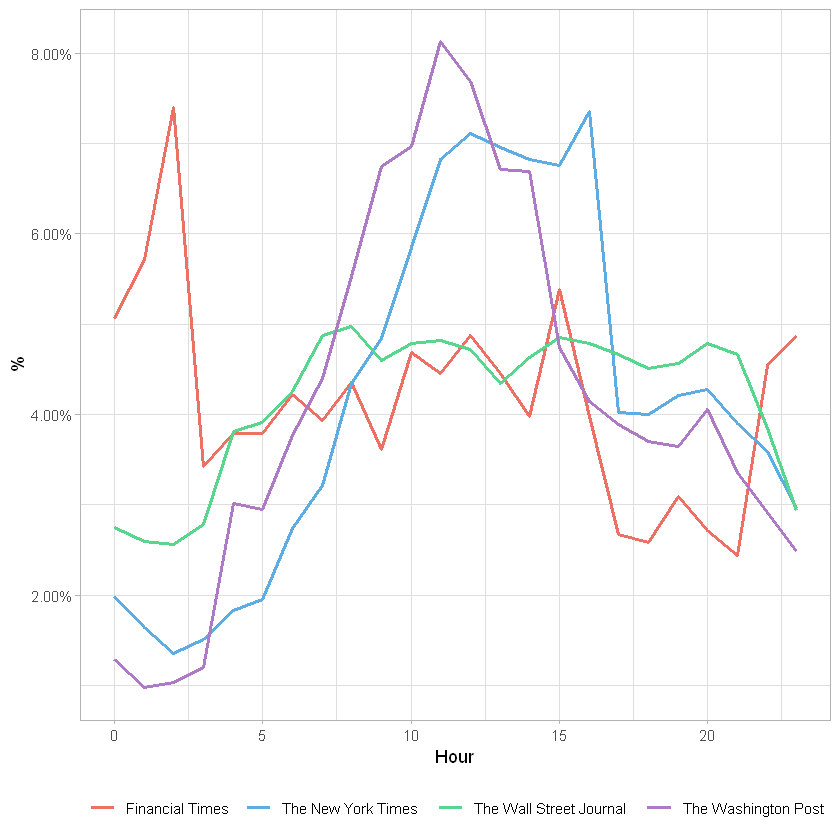

In [16]:
# line plot
tw_media %>%
  count(name, hour = hour(with_tz(date, 'EST'))) %>%
  group_by(name) %>%
  mutate(percent = n / sum(n)) %>%
  ggplot(aes(hour, percent, color = name)) +
  geom_line(size = 1) +
  scale_y_continuous(labels = percent_format(accuracy = 0.01)) +
  xlab("Hour") +
  ylab("%") +
  scale_color_manual(values = color1) +
  theme(legend.position = "bottom",
        legend.title = element_blank())

### Lenght and number of words

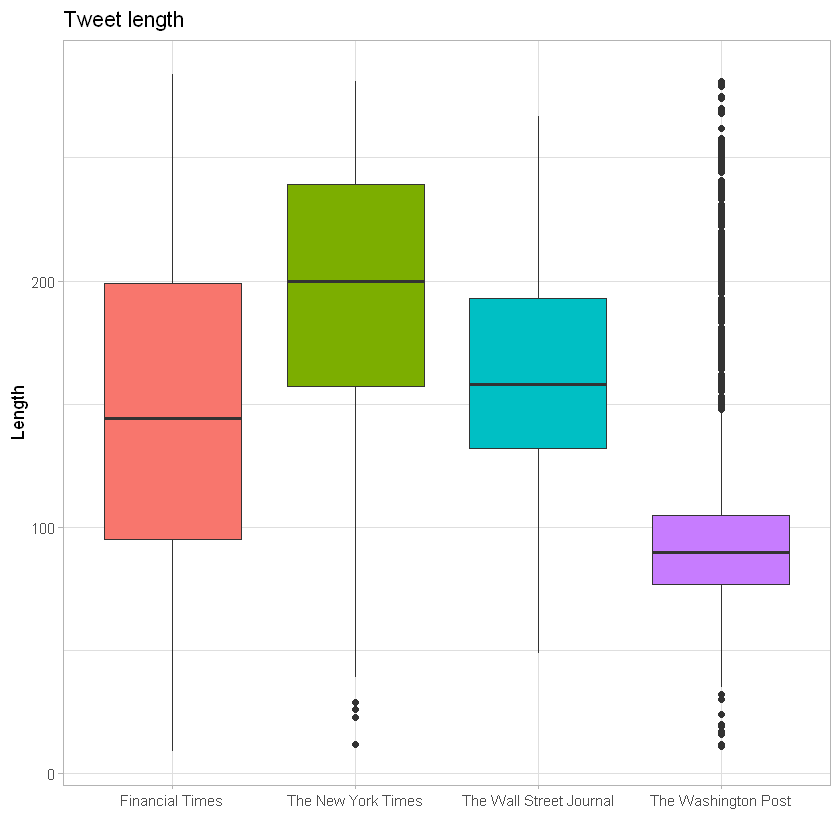

In [17]:
# length of tweet
tw_media %>%
  mutate(text = str_replace_all(text, "https://t.co/[A-Za-z\\d]+|&amp;|(?<=)<(.*?)(?=>)>", "")) %>% 
  mutate(length = nchar(text)) %>%
  ggplot(aes(x=name, y=length, fill = name)) +
  geom_boxplot(show.legend = FALSE) +
  ggtitle("Tweet length") +
  xlab("") +
  ylab("Length")

In terms of lenght, the NYT has a higher median than the rest of outlets. The WP has the lowest median and a group of outliers at both ends of the distribution. As most of those outliers are on the higher end of the distribution I checked a random sample of tweets with more than 150 characters to see if there is any reason as to why they are longer than average. It doesn't appear to be a clear trend other than these tweets sometimes are quoting an individual.

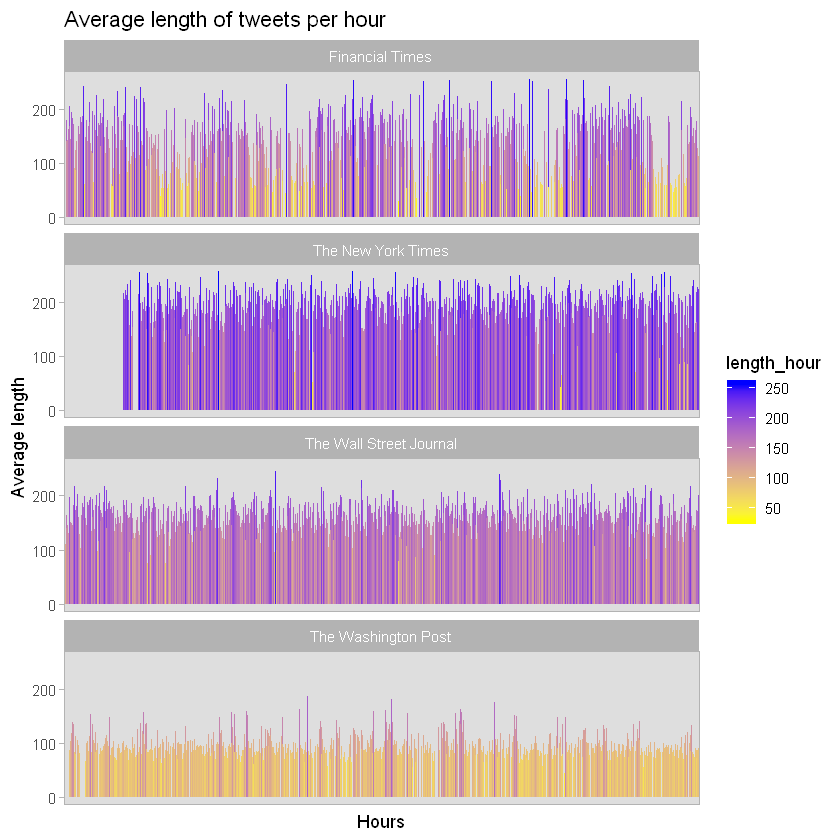

In [18]:
#distribution according status_id
tw_media %>%
  mutate(text = str_replace_all(text, "https://t.co/[A-Za-z\\d]+|&amp;|(?<=)<(.*?)(?=>)>", "")) %>%
  mutate(length = nchar(text),
         date_simp = date(with_tz(date, 'EST')),
         hour = hour(with_tz(date, 'EST'))) %>%
  group_by(name, date_simp, hour) %>%
  mutate(length_hour = mean(length),
         date = paste(date_simp,hour, sep = "-")) %>%
  select(name, date, date_simp, hour, length_hour) %>% unique() %>%
  ggplot(aes(x=date, y=length_hour, fill = length_hour)) +
  geom_bar(stat = 'identity') +
  ggtitle("Average length of tweets per hour") +
  xlab("Hours") +
  ylab("Average length") +
  scale_fill_gradient(low = "yellow", high = "blue") +
  facet_wrap(.~name, ncol = 1) +
  theme(panel.background = element_rect(fill = "white"),
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank())